In [62]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
from keras.optimizers import RMSprop
df=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [63]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
df.shape

(42000, 785)

In [65]:
X=df.drop(columns='label')
Y= df.label
X=X/255.0
X= X.astype('float32')
Y= Y.astype('int32')

In [66]:
X = X.to_numpy().reshape(-1, 28, 28,1)
mean_px = X.mean().astype(np.float32)
std_px = X.std().astype(np.float32)
X=(X-mean_px)/std_px

In [67]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train, y_val=train_test_split(X,Y, test_size=0.33,random_state=42)

In [68]:
from keras.preprocessing import image
from tensorflow import keras
gen =image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  


gen.fit(X_train)
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_val = keras.utils.to_categorical(y_val, num_classes=10)

In [69]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [70]:
model = keras.Sequential([
    layers.Conv2D(32,(3,3),input_shape=(28, 28,1), activation='relu',padding = 'Same'),
    layers.BatchNormalization(axis=1),
    layers.Conv2D(32,(3,3), activation='relu',padding = 'Same'),
    layers.BatchNormalization(axis=1),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,(3,3), activation='relu',padding = 'Same'),
    layers.BatchNormalization(axis=1),
    layers.Conv2D(64,(3,3), activation='relu',padding = 'Same'),
    layers.BatchNormalization(axis=1),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax'),
])


model.compile(loss="categorical_crossentropy",
              optimizer= RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])
    

history = model.fit_generator(
    gen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] // 32,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[learning_rate_reduction],
    verbose=1,
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_32/3341572354.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


879/879 [==============================] - 13s 13ms/step - loss: 0.3988 - accuracy: 0.8854 - val_loss: 0.0917 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 2/30
879/879 [==============================] - 11s 13ms/step - loss: 0.1323 - accuracy: 0.9620 - val_loss: 0.0430 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 3/30
879/879 [==============================] - 11s 13ms/step - loss: 0.1088 - accuracy: 0.9713 - val_loss: 0.0607 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 4/30
879/879 [==============================] - 11s 13ms/step - loss: 0.0912 - accuracy: 0.9757 - val_loss: 0.0371 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 5/30
879/879 [==============================] - 11s 12ms/step - loss: 0.0815 - accuracy: 0.9778 - val_loss: 0.0377 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 6/30
879/879 [==============================] - 11s 13ms/step - loss: 0.0810 - accuracy: 0.9798 - val_loss: 0.0330 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 7/30
879/879 [==============================] - 11s 13ms/step -

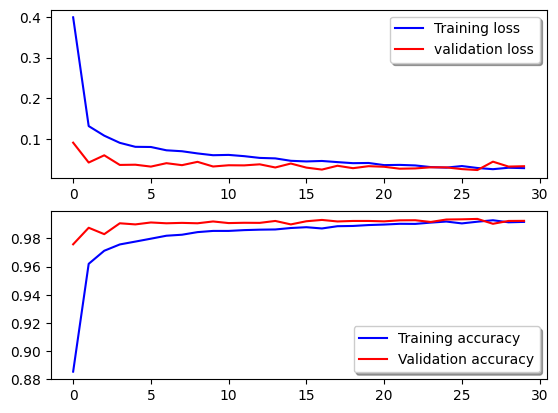

In [71]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

434/434 [==============================] - 1s 2ms/step


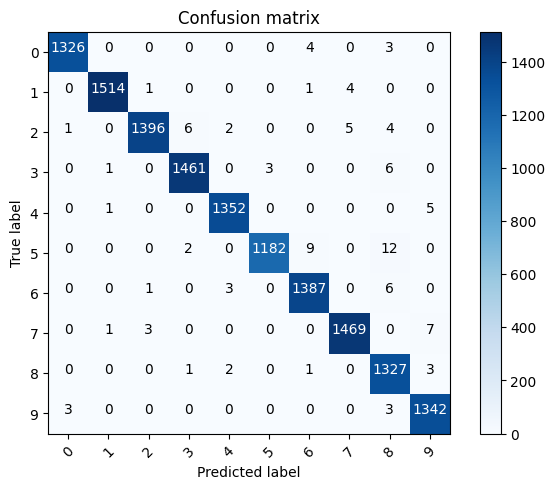

In [72]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true =  np.argmax(y_val,axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [73]:
df_test=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test=df_test/255.0
X_test = X_test.to_numpy().reshape(-1, 28, 28,1)
y_test_pred_model = model.predict(X_test)

875/875 [==============================] - 2s 2ms/step


In [74]:
values=np.argmax(y_test_pred_model, axis=1)
y_test_pred=pd.DataFrame(values , columns=['Label'])
image_id= pd.DataFrame(list(range(1, X_test.shape[0]+1)), columns=['ImageId'])
csv_out= pd.concat([image_id,y_test_pred],axis=1)
csv_out.to_csv('Number_recognition_CNN.csv', index=False, header=True)

In [75]:
# from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsClassifier
# for components in [400]:
#     pca = PCA(n_components=components, whiten=True)
#     X_train_copy= X_train
#     X_val_copy= X_val
#     X_train_pca= pca.fit_transform(X_train_copy)
#     X_val_pca =pca.transform(X_val_copy)
#     knn.fit(X_train_pca, y_train)
#  score = 0,6
#     print("n_components= {}, score= {}".format(components, knn.score( X_val_pca, y_val)))

In [76]:
# from sklearn.decomposition import NMF
# nmf= NMF(n_components=200)
# X_train_copy= X_train
# X_val_copy= X_val
# X_train_nmf= nmf.fit_transform(X_train_copy)
# X_val_nmf =nmf.transform(X_val_copy)
# knn.fit(X_train_nmf, y_train)
# score =0.8
# print("n_components= {}, score= {}".format(components, knn.score( X_val_nmf, y_val)))